# Face Track Project 

## Workflow

1. Take 90 pictures of my face
2. label them using "labelme" in base cuda enviroment
3. Split them in to 3 dataset: train, test, validation
4. Augment the dataset using albumentation
5. Import dataset to tensor
6. Define the model and train it

In [1]:
import cv2
import os
import uuid
import time
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
IMAGE_PATH = os.path.join('data', 'images')
number_images = 30

In [ ]:
# read images

cap = cv2.VideoCapture(0)

for imgnum in range (number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGE_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.test.is_gpu_available()

False

In [ ]:
# Load images into TF Data Pipeline
images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)
images.as_numpy_iterator().next()

In [3]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img


In [ ]:
images = images.map(load_image) 

In [ ]:
# Plot images
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols = 4, figsize=(20, 20))
for i, image in enumerate(plot_images):
    ax[i].imshow(image)
plt.show()

In [20]:
# After split data into 3 folders train, test, val, we move the matching labels
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data',folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [7]:
import albumentations as alb

In [27]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), alb.HorizontalFlip(p=0.5), alb.RandomBrightnessContrast(p=0.2), alb.RandomGamma(p=0.2), alb.RGBShift(p=0.2), alb.VerticalFlip(p=0.5)], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [29]:
# Build and Run Augmentation Pipeline

for partition in ['train', 'test', 'val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))
        
        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes = [coords], class_labels = ["my_face"])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.24750905797101447, 0.44867149758454106, 0.0006793478260869401, 0.8743961352657005, 'my_face'].
x_max is less than or equal to x_min for bbox [0.18108393719806765, 0.536231884057971, 0.0014341787439613451, 0.9468599033816426, 'my_face'].
x_max is less than or equal to x_min for bbox [0.17504528985507248, 0.5271739130434783, 0.002189009661835739, 0.9398148148148149, 'my_face'].
x_max is less than or equal to x_min for bbox [0.20070954106280192, 0.5241545893719807, 0.0, 0.9310862930998088, 'my_face'].


In [4]:
# Load augmented Images to tf dataset

train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x:tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x:tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x:tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [6]:
# labels loading function
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [7]:
# load labels to tf dataset
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [8]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.02747, 0.2983 , 0.4226 , 0.819  ], dtype=float16))

In [9]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3600, 3600, 780, 780, 780, 780)

In [11]:
# Create final dataset
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


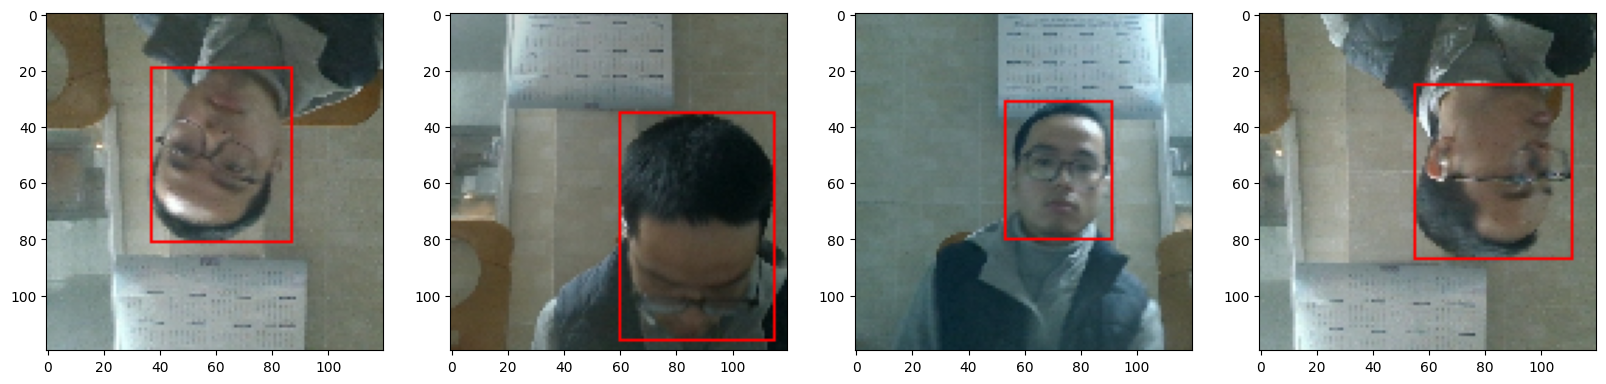

In [19]:
# View Images and Annotation

data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize = (20, 20))
for i in range (4):
    sample_image = res[0][i]
    sample_coords = res[1][1][i]
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)), 
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                  (255,0,0), 1)
    ax[i].imshow(sample_image)

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPool2D
from tensorflow.keras.applications import VGG16

In [23]:
vgg = VGG16(include_top=False)
vgg.summary()

58889256/58889256 [==============================] - 14s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                             

In [24]:
# classification layers and regression layers

def build_model():
    input_layer = Input(shape = (120, 120, 3))

    vgg = VGG16(include_top=False)(input_layer)

    # Binary Classification model (Is an object or not) 
    f1 = GlobalMaxPool2D()(vgg)
    class1 = Dense(2048, activation= 'relu')(f1)
    class2 = Dense(1, activation='relu')(class1)

    # Bounding box model (what is the value of x1,y1,x2,y2)
    f2 = GlobalMaxPool2D()(vgg)
    regress1 = Dense(2048, activation= 'relu')(f1)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker


In [25]:
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [32]:
# Define Optimizer and Learning Rate, Optimizers
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/batches_per_epoch
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [48]:
# Define Localization Loss
def localization_loss(y_true, y_hat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2]-y_hat[:, :2]))

    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]

    h_pred = y_hat[:, 3] - y_hat[:, 1]
    w_pred = y_hat[:, 2] - y_hat[:, 0]

    delta_size = tf.reduce_sum(tf.square(w_true-w_pred)+tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [49]:
class_loss = tf.keras.losses.BinaryCrossentropy()
regress_loss = localization_loss

In [61]:
# Create custom the model class
class FaceTracker(Model):
    def __init__(self, facetracker):
        super().__init__()
        self.model = facetracker
    
    def compile(self, opt, class_loss, regress_loss):
        super().compile()
        self.closs = class_loss
        self.lloss = regress_loss
        self.opt = opt

    def train_step(self, batch):
        X, y = batch
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training = True)

            batch_class_loss = self.closs(y[0], classes)
            batch_regress_loss = self.lloss(tf.cast(y[1],tf.float32), coords)
            total_loss = batch_regress_loss + 0.5*batch_class_loss

            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_class_loss, "regress_loss":batch_regress_loss}
    
    def test_step(self, batch):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_class_loss = self.closs(y[0], classes)
        batch_regress_loss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_regress_loss + 0.5*batch_class_loss

        return {"total_loss":total_loss, "class_loss":batch_class_loss, "regress_loss":batch_regress_loss}

    def call(self, X):
        return self.model(X)

In [62]:
# Create object
model = FaceTracker(facetracker)

In [63]:
model.compile(opt, class_loss, regress_loss)

In [64]:
# create callback (save weights)
logdir = 'callback'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [65]:
history = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
450/450 [==============================] - 1111s 2s/step - total_loss: 0.1195 - class_loss: 0.2071 - regress_loss: 0.0160 - val_total_loss: 0.0080 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0080
Epoch 2/10
450/450 [==============================] - 1085s 2s/step - total_loss: 0.1153 - class_loss: 0.2071 - regress_loss: 0.0118 - val_total_loss: 0.0071 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0071
Epoch 3/10
450/450 [==============================] - 942s 2s/step - total_loss: 0.1104 - class_loss: 0.2071 - regress_loss: 0.0068 - val_total_loss: 2.0021 - val_class_loss: 3.8123 - val_regress_loss: 0.0959
Epoch 4/10
450/450 [==============================] - 904s 2s/step - total_loss: 0.1102 - class_loss: 0.2071 - regress_loss: 0.0067 - val_total_loss: 0.0070 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0070
Epoch 5/10
450/450 [==============================] - 929s 2s/step - total_loss: 0.1100 - class_loss: 0.2071 - regress_loss: 0.0065 - val_total_loss: 

In [67]:
# save model
facetracker.save('facetracker.h5')

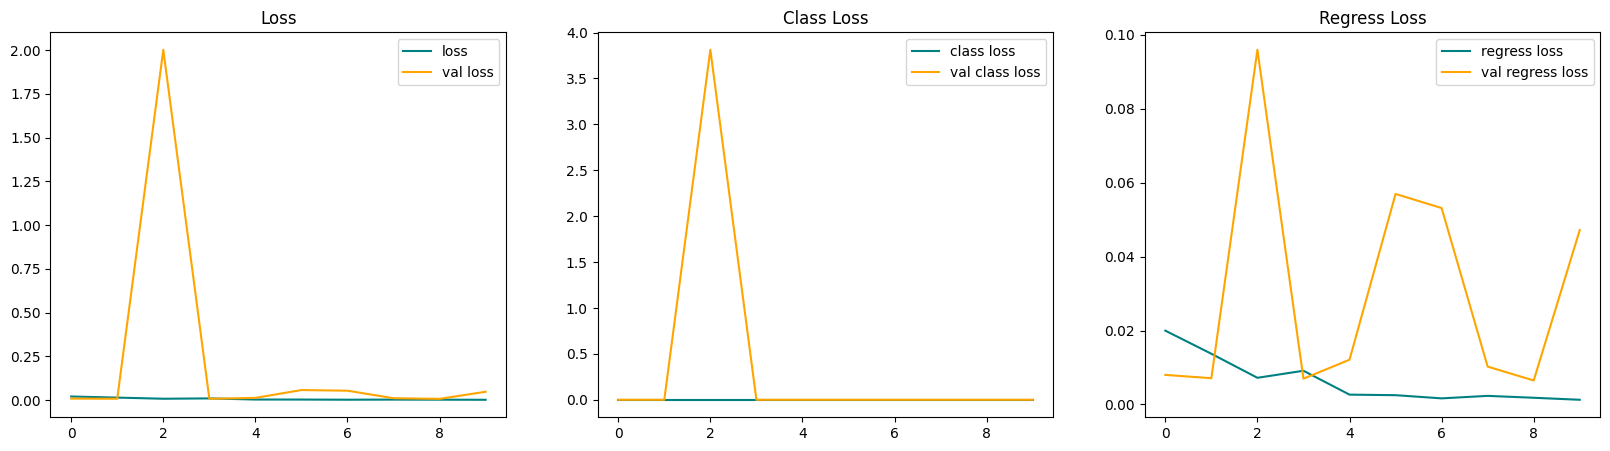

In [68]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(history.history['total_loss'], color='teal', label="loss")
ax[0].plot(history.history['val_total_loss'], color='orange', label="val loss")
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history.history['class_loss'], color='teal', label="class loss")
ax[1].plot(history.history['val_class_loss'], color='orange', label="val class loss")
ax[1].title.set_text('Class Loss')
ax[1].legend()

ax[2].plot(history.history['regress_loss'], color='teal', label="regress loss")
ax[2].plot(history.history['val_regress_loss'], color='orange', label="val regress loss")
ax[2].title.set_text('Regress Loss')
ax[2].legend()

plt.show()

In [2]:
# Load model
from tensorflow.keras.models import load_model
facetracker = load_model('facetracker.h5')

In [3]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    y_hat = facetracker.predict(np.expand_dims(resized/255, 0))
    sample_coords = y_hat[1][0]

    if y_hat[0] > 0.5:
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                      (255, 0, 0), 2)
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [0, -30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [140, 0])),
                      (255, 0, 0), -1)
        cv2.putText(frame, 'my_face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.imshow('FaceTrack', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 243ms/step
